In [1]:
import time
import numpy as np
import pymc3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from pprint import pprint
from sklearn.cluster import KMeans

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/legmint/.local/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
rng = np.random.RandomState(42)

source : http://approximateinference.org/2017/accepted/Zinkov2017.pdf
source : https://towardsdatascience.com/implement-expectation-maximization-em-algorithm-in-python-from-scratch-f1278d1b9137

In [3]:
df = pd.read_csv("../data/X_station_day.csv")

In [4]:
df.rename(columns={"precipitations": "current_precipitations"}, inplace=True)

## EM
 M-step :

$$ \pi = \frac{\sum_{i=1}^{n}\mathcal{Q}(y^i=1|x^i)}{n} $$

$$ \mu_j = \frac{\sum_{i=1}^{n}x^i\mathcal{Q}(y^i=j|x^i)}{\sum_{i=1}^{n}\mathcal{Q}(y^i=j|x^i)} $$

$$ \Sigma_j = \frac{\sum_{i=1}^{n}\mathcal{Q}(y^i=j|x^i)(x^i-\mu_j)(x^i-\mu_j)^T}{\sum_{i=1}^{n}\mathcal{Q}(y^i=j|x^i)} $$

In [18]:
class EM():
    def __init__(self, x: np.ndarray, nb_dist=2, split_ratio=0.1, threshold=0.01, minimum_sigma=1e-5, talk=False):
        self.talk = talk  # whether to display information or not
        self.threshold = threshold  # threshold ratio to trigger stop_fitting
        self.minimum_sigma = minimum_sigma  # to avoid sigma being 0
        self.stop_fitting = False  # stop fitting if maximum iterations reached or threshold passed
        self.nb_dist = nb_dist  # number of distributions to fit

        self.split_ratio = split_ratio  # part of x to keep to initialize the parameters
        self.x_all = x  # backup of whole x data
        self.idx_sample = None  # index of x_sample for initialization
        self.x_sample = None  # sample for initialization
        self.x = None  # training part of x
        self.split_x()  # fill x_sample, idx_sample and x

        self.mu = None  # average
        self.sigma = None  # standard deviation
        self.w = None  # weights
        self.init_params()  # initialize the above

        self.history = None  # history
        self.init_history()  # initialize history

        self.r = None  # declare r to anticipate fit()

        self.history_record = None  # declare variable, used in average_fit()
        self.clustered_distributions = None  # declare variable, used in average_fit()

        self.colors = ["blue", "red", "orange", "green", "magenta"]

    def split_x(self):
        self.idx_sample = rng.choice(np.arange(self.x_all.shape[0]),
                                     replace=False,
                                     size=int(self.x_all.shape[0] * self.split_ratio))
        self.x_sample = self.x_all[self.idx_sample]
        self.x = np.delete(self.x_all, self.idx_sample, axis=0)

    def init_params(self):
        mu = rng.normal(loc=np.mean(self.x_sample),
                        scale=5,
                        size=self.nb_dist)
        sigma = np.abs(rng.normal(loc=np.sqrt(np.var(self.x_sample)),
                                  scale=2,
                                  size=self.nb_dist))
        w = np.abs(rng.normal(loc=1,
                              scale=0.2,
                              size=self.nb_dist))
        w /= w.sum()
        if self.talk:
            print("Initial parameters :")
            print("\t - mu :    {}".format(np.round(mu, 2)))
            print("\t - sigma : {}".format(np.round(sigma, 2)))
            print("\t - w :     {}".format(np.round(w, 2)))
        self.mu, self.sigma, self.w = mu, sigma, w

    def init_history(self):
        history = {"mu": [self.mu],
                   "sigma": [self.sigma],
                   "w": [self.w]}
        self.history = history

    def update_h(self):
        self.history["mu"].append(self.mu)
        self.history["sigma"].append(self.sigma)
        self.history["w"].append(self.w)

    def e_step(self):
        x = self.x[None, :]
        mu = self.mu[:, None]
        sigma = self.sigma[:, None]
        # r is the probability of each point of x given the normal distribution N(mu,sigma)
        self.r = stats.norm.pdf(x, mu, sigma)
        self.r = self.r / self.r.sum(axis=0)

    def m_step(self):
        n = self.x.shape[0]
        self.w = np.sum(self.r, axis=1) / n
        self.mu = np.sum(self.x * self.r, axis=1) / np.sum(self.r, axis=1)
        sigma = []
        for j in range(self.nb_dist):
            sigma.append(
                np.sqrt(np.sum(self.r[j, :] * (self.x - self.mu[j]) * (self.x - self.mu[j])) / np.sum(self.r[j, :])))
            if sigma[-1] < self.minimum_sigma:
                print(
                    "WARNING : sigma < minimum_sigma - {:.7f} < {:.7f}".format(sigma[-1], self.minimum_sigma).ljust(70),
                    end="\r")
                sigma[-1] = self.minimum_sigma
        self.sigma = np.array(sigma)

    def fit(self, max_iters=100, plot=False):
        self.stop_fitting = False
        for i in range(max_iters):
            if self.talk and i % int(max_iters // 100 + 1) == 0:
                print("{} %".format(int(i / max_iters * 100)).rjust(5), end="\r")

            self.e_step()
            self.m_step()
            self.update_h()

            self.check_change()
            if self.stop_fitting:
                break

        if self.talk:
            print("\n")
            if self.stop_fitting:
                print("Threshold reached, less than {} % difference.".format(self.threshold * 100))
            else:
                print("100 %")
            print("Final parameters :\n\tmu :    {}\n\tsigma : {}\n\tw :     {}".format(self.history["mu"][-1],
                                                                                        self.history["sigma"][-1],
                                                                                        self.history["w"][-1]))

        if plot:
            self.plot_progression()

    def check_change(self):
        mu_old = self.history["mu"][-2]
        sigma_old = self.history["sigma"][-2]
        w_old = self.history["w"][-2]
        if any(self.mu == 0):
            delta_mu = np.max(np.abs((mu_old - self.mu) / (self.mu + 1)))
        else:
            delta_mu = np.max(np.abs((mu_old - self.mu) / self.mu))
        delta_sigma = np.max(np.abs((sigma_old - self.sigma) / self.sigma))
        if any(self.w == 0):
            delta_w = np.max(np.abs((w_old - self.w) / (self.w + 1)))
        else:
            delta_w = np.max(np.abs((w_old - self.w) / self.w))
        delta = max(delta_mu, delta_sigma, delta_w)
        if delta < self.threshold:
            self.stop_fitting = True

    def average_fit(self, runs=3, max_iters=100, plot=True, plot_title=""):
        """
        to avoid initialization issues, average over [runs] fit() and different initializations.
        :param plot_title: title of the plot of plot
        :param runs: number of fit() to execute
        :param max_iters: maximum number of iterations for each fit()
        :param plot: plot the final result, average of all fit()

        updates to history to every parameters fo every fit() (for plotting purpose) and parameters to average of every run.
        """

        history_record = pd.DataFrame(columns=["mu", "sigma", "w"])
        for i in range(runs):
            if self.talk :
                print("\nRun number {} over {}.".format(i,runs))
            # reset everything at each run
            self.init_params()
            self.init_history()
            self.split_x()

            self.fit(max_iters=max_iters)

            for j in range(self.nb_dist):
                history_record = history_record.append(pd.DataFrame({"mu": [self.history["mu"][-1][j]],
                                                                     "sigma": [self.history["sigma"][-1][j]],
                                                                     "w": [self.history["w"][-1][j]]}),
                                                       ignore_index=True)

        history_record_scaled = (history_record - history_record.min()) / (history_record.max() - history_record.min())
        kmeans = KMeans(init="random", n_clusters=self.nb_dist, n_init=10, max_iter=300, random_state=42)
        history_record["cluster"] = kmeans.fit_predict(history_record_scaled)
        self.history_record = history_record.sort_values(by="cluster", ignore_index=True)

        clustered_distributions = pd.DataFrame(columns=["mu", "sigma", "w"])
        for i in range(self.nb_dist):
            mu = history_record[history_record['cluster'] == i]["mu"].mean()
            sigma = history_record[history_record['cluster'] == i]["sigma"].mean()
            w = history_record[history_record['cluster'] == i]["w"].mean()
            clustered_distributions = clustered_distributions.append(
                pd.DataFrame({"mu": [mu],
                              "sigma": [sigma],
                              "w": [w]}),
                ignore_index=True
            )
        clustered_distributions["w"] /= clustered_distributions["w"].sum()

        self.clustered_distributions = clustered_distributions

        if self.talk :
            print("\n\n","="*25,"\nFinal average parameters :\n\tmu :    {}\n\tsigma : {}\n\tw :     {}".format(self.clustered_distributions["mu"].tolist(),
                                                                                        self.clustered_distributions["sigma"].tolist(),
                                                                                        self.clustered_distributions["w"].tolist()))

        if plot:
            if not plot_title :
                plot_title = "Average fit over {} runs".format(runs)
            self.plot_average(title=plot_title)

    ###########################
    ### POT FUNCTIONS BELOW ###
    ###########################

    def plot_average(self, figsize=(14, 6), title="specific_plot", save=True):
        abscisse = np.linspace(self.x_all.min(), self.x_all.max(), 1001)

        plt.figure(figsize=figsize)
        plt.suptitle(title)

        # hist plots
        ax0 = plt.subplot2grid(shape=(1,2), loc=(0,0))
        ax0.set_title("Averaged distributions by {}-means".format(len(self.clustered_distributions)))
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability", ax=ax0)

        ax1 = plt.subplot2grid(shape=(1,2), loc=(0,1))
        ax1.set_title("All distributions overs {} runs".format(len(self.clustered_distributions)))
        mu_s = self.clustered_distributions["mu"]
        sigma_s = self.clustered_distributions["sigma"]
        w_s = self.clustered_distributions["w"]
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability", ax=ax1)

        # find y_limit
        y_lim_top = min(1, ax0.set_ylim(auto=True)[1], ax1.set_ylim(auto=True)[1])

        # line plots
        for j in range(len(self.history_record)):
            ax0.plot(abscisse,
                     self.history_record.loc[j,"w"] * stats.norm.pdf(abscisse,
                                                                     self.history_record.loc[j,"mu"],
                                                                     self.history_record.loc[j,"sigma"]),
                     color=self.colors[self.history_record.loc[j,"cluster"]])

        for j in range(self.nb_dist):
            ax1.plot(abscisse,
                     w_s[j] * stats.norm.pdf(abscisse,
                                             mu_s[j],
                                             sigma_s[j]),
                     color=self.colors[j])

        # set y_limit
        ax0.set_ylim(top=y_lim_top)
        ax1.set_ylim(top=y_lim_top)

        if save:
            plt.savefig(title.replace(" ", "_") + ".jpg")
        plt.show()

    def plot_step(self, step_index, figsize=(10, 7)):
        mu = self.history["mu"][step_index]
        sigma = self.history["sigma"][step_index]
        w = self.history["w"][step_index]

        plt.figure(figsize=figsize)
        plt.title("step_index : {}".format(step_index))
        abscisse = np.linspace(self.x_all.min(), self.x_all.max(), 1001)
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability")
        for j in range(self.nb_dist):
            plt.plot(abscisse, w[j] * stats.norm.pdf(abscisse, mu[j], sigma[j]))
        plt.show()

    def plot_params(self, figsize=(10, 7), title="Current parameters"):
        plt.figure(figsize=figsize)
        plt.title(title)
        abscisse = np.linspace(self.x_all.min(), self.x_all.max(), 1001)
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability")
        for j in range(self.w.shape[0]):
            plt.plot(abscisse, self.w[j] * stats.norm.pdf(abscisse, self.mu[j], self.sigma[j]))
        plt.show()

    def plot_progression(self, figsize=(20, 6), title="Expectation Maximization", save=True):
        abscisse = np.linspace(self.x_all.min(), self.x_all.max(), 1001)

        plt.figure(figsize=figsize)
        ax0 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), rowspan=3)
        ax1_0 = plt.subplot2grid(shape=(3, 3), loc=(0, 1))
        ax1_1 = plt.subplot2grid(shape=(3, 3), loc=(1, 1))
        ax1_2 = plt.subplot2grid(shape=(3, 3), loc=(2, 1))
        ax2 = plt.subplot2grid(shape=(3, 3), loc=(0, 2), rowspan=3)

        # hist plot
        ax0.set_title("Initialization")
        mu_init = self.history["mu"][0]
        sigma_init = self.history["sigma"][0]
        w_init = self.history["w"][0]
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability", ax=ax0)

        ax2.set_title("After {} steps".format(len(self.history["mu"]) - 1))
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability", ax=ax2)

        # find y_limit
        y_lim_top = min(1, ax0.set_ylim(auto=True)[1], ax2.set_ylim(auto=True)[1])

        # line plot
        for j in range(self.nb_dist):
            ax0.plot(abscisse, w_init[j] * stats.norm.pdf(abscisse, mu_init[j], sigma_init[j]))
        for j in range(self.w.shape[0]):
            ax2.plot(abscisse, self.w[j] * stats.norm.pdf(abscisse, self.mu[j], self.sigma[j]))

        # set y_limit
        ax0.set_ylim(top=y_lim_top)
        ax2.set_ylim(top=y_lim_top)

        ax1_0.set_title("parameters")
        for i in range(self.nb_dist):
            sns.lineplot(x=np.arange(len(self.history["mu"])),
                         y=np.array(self.history["mu"])[:, i],
                         ax=ax1_0,
                         label="{}".format(i),
                         palette=sns.color_palette("hls", 8))
        ax1_0.set_ylabel("mu")
        ax1_0.set_xticks([])
        for i in range(self.nb_dist):
            sns.lineplot(x=np.arange(len(self.history["sigma"])),
                         y=np.array(self.history["sigma"])[:, i],
                         ax=ax1_1,
                         label="{}".format(i),
                         palette=sns.color_palette("hls", 8))
        ax1_1.set_ylabel("sigma")
        ax1_1.set_xticks([])
        for i in range(self.nb_dist):
            sns.lineplot(x=np.arange(len(self.history["w"])),
                         y=np.array(self.history["w"])[:, i],
                         ax=ax1_2,
                         label="{}".format(i),
                         palette=sns.color_palette("hls", 8))
        ax1_2.set_ylabel("w")
        ax1_2.set_xlabel("steps")
        x_ticks = [i for i in range(len(self.history["w"]))]
        step = len(x_ticks) // 20 + 1
        x_ticks = x_ticks[::step]
        ax1_2.set_xticks(x_ticks)

        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        if save:
            plt.savefig(title.replace(" ", "_") + ".jpg")
        plt.show()




	 wind_speed



Initial parameters :
	 - mu :    [15.17 -0.03]
	 - sigma : [2.8  0.82]
	 - w :     [0.55 0.45]

Run number 0 over 5.
Initial parameters :
	 - mu :    [10.11  7.84]
	 - sigma : [3.75 0.44]
	 - w :     [0.34 0.66]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [2.58115567 4.61983294]
	sigma : [0.89406022 2.23664272]
	w :     [0.52609782 0.47390218]

Run number 1 over 5.
Initial parameters :
	 - mu :    [ 0.97 -5.67]
	 - sigma : [0.42 1.91]
	 - w :     [0.55 0.45]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [2.57535594 4.62204827]
	sigma : [0.89184348 2.23322851]
	w :     [0.52554514 0.47445486]

Run number 2 over 5.
Initial parameters :
	 - mu :    [9.06 2.9 ]
	 - sigma : [3.5 1.3]
	 - w :     [0.42 0.58]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [4.61851775 2.5820004 ]
	sigma : [2.23696123 0.89515571]
	w :     [0.47376207 0.52623793]

Run number 3 over 5.
I

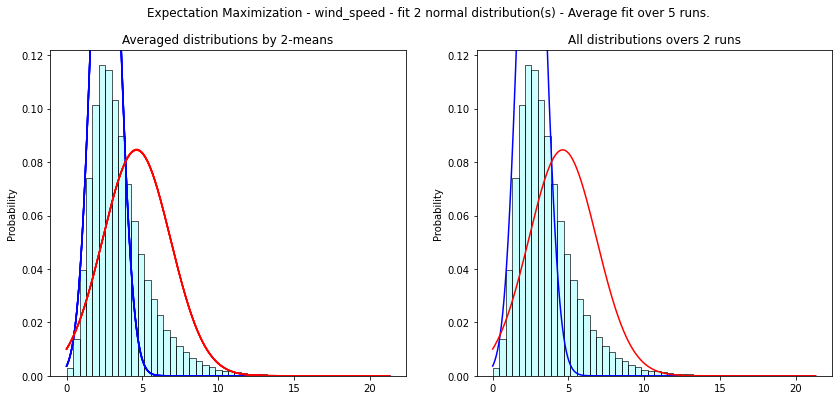

elapsed : 1.37 s.
Initial parameters :
	 - mu :    [-2.22  3.84  9.88]
	 - sigma : [3.81 1.62 4.74]
	 - w :     [0.32 0.53 0.15]

Run number 0 over 5.
Initial parameters :
	 - mu :    [-1.84  2.27  0.93]
	 - sigma : [1.91 2.93 2.3 ]
	 - w :     [0.25 0.36 0.39]
  3 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [2.10391717 5.16562979 3.49230063]
	sigma : [0.68649831 2.39837297 0.94707235]
	w :     [0.34152255 0.3157845  0.34269295]

Run number 1 over 5.
Initial parameters :
	 - mu :    [ 4.09  2.09 10.59]
	 - sigma : [0.75 1.55 0.85]
	 - w :     [0.31 0.4  0.29]
  4 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [3.49276041 2.10035081 5.16895035]
	sigma : [0.94399297 0.68592168 2.39883607]
	w :     [0.34269544 0.34147284 0.31583172]

Run number 2 over 5.
Initial parameters :
	 - mu :    [ 2.4   8.05 -0.59]
	 - sigma : [2.72 0.77 4.87]
	 - w :     [0.43 0.29 0.29]
  5 %

Threshold reached, less than 0.1 % difference.
Final pa

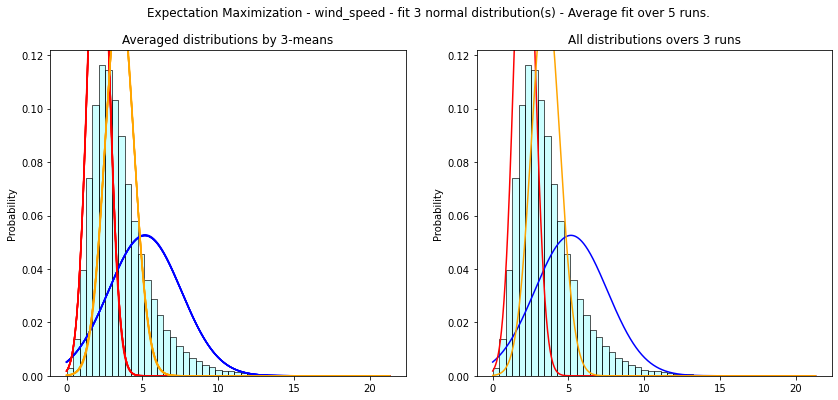

elapsed : 3.30 s.
Initial parameters :
	 - mu :    [ 4.38 -0.91  0.7   2.01]
	 - sigma : [6.09 1.88 1.9  4.27]
	 - w :     [0.21 0.35 0.28 0.16]

Run number 0 over 5.
Initial parameters :
	 - mu :    [ 8.75  7.62  9.07 -2.62]
	 - sigma : [2.61 1.77 1.17 3.25]
	 - w :     [0.26 0.21 0.26 0.26]
 14 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [2.92322736 4.0111813  5.53795464 1.84143976]
	sigma : [0.67691952 1.05849626 2.51232374 0.59187617]
	w :     [0.25421943 0.25414281 0.23784622 0.25379154]

Run number 1 over 5.
Initial parameters :
	 - mu :    [ 4.12 -5.15  2.14  4.09]
	 - sigma : [3.15 0.76 2.25 2.78]
	 - w :     [0.17 0.25 0.21 0.36]
  4 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [5.54887105 1.8120139  2.89067236 4.0499715 ]
	sigma : [2.50244618 0.57648233 0.62620945 0.9961518 ]
	w :     [0.23861867 0.25335181 0.25402349 0.25400604]

Run number 2 over 5.
Initial parameters :
	 - mu :    [5.99 6.36 4.6  3.59]
	 - 

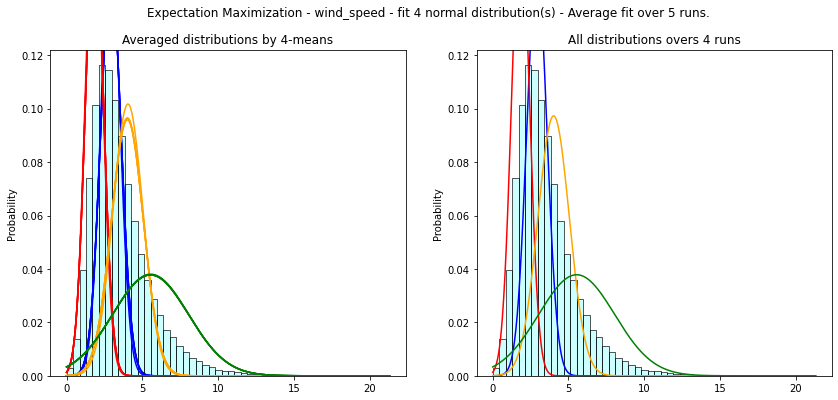

elapsed : 13.12 s.



	 temperature



Initial parameters :
	 - mu :    [280.94 289.36]
	 - sigma : [7.15 6.68]
	 - w :     [0.57 0.43]

Run number 0 over 5.
Initial parameters :
	 - mu :    [280.14 284.22]
	 - sigma : [7.68 2.8 ]
	 - w :     [0.39 0.61]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [285.49484229 284.2971183 ]
	sigma : [5.76324985 5.54020306]
	w :     [0.50003 0.49997]

Run number 1 over 5.
Initial parameters :
	 - mu :    [295.14 284.3 ]
	 - sigma : [6.95 7.53]
	 - w :     [0.5 0.5]
  3 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [288.87598688 280.9383404 ]
	sigma : [4.21800148 3.91308193]
	w :     [0.49829437 0.50170563]

Run number 2 over 5.
Initial parameters :
	 - mu :    [288.88 291.29]
	 - sigma : [8.33 0.25]
	 - w :     [0.51 0.49]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [280.90890743 288.91433928]
	sigma : [3.88456035 4.186196  ]
	w :     [0.50214792

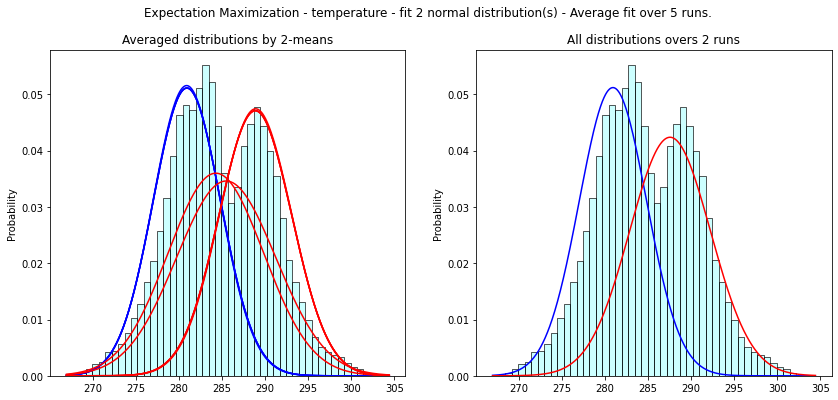

elapsed : 1.62 s.
Initial parameters :
	 - mu :    [279.52 280.49 280.28]
	 - sigma : [1.77 9.2  5.72]
	 - w :     [0.33 0.3  0.37]

Run number 0 over 5.
Initial parameters :
	 - mu :    [288.49 289.88 293.25]
	 - sigma : [3.68 7.51 7.51]
	 - w :     [0.35 0.32 0.32]
  9 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [289.43155882 281.11924448 284.23345886]
	sigma : [3.32072109 2.88538887 6.5113219 ]
	w :     [0.32909527 0.3354881  0.33541662]

Run number 1 over 5.
Initial parameters :
	 - mu :    [284.7  284.93 298.62]
	 - sigma : [2.59 6.16 4.49]
	 - w :     [0.33 0.38 0.29]
 12 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [281.16880081 284.10375111 289.50094573]
	sigma : [2.89009064 6.46564696 3.32832778]
	w :     [0.33537666 0.33547176 0.32915158]

Run number 2 over 5.
Initial parameters :
	 - mu :    [282.3  287.28 286.89]
	 - sigma : [7.38 6.63 6.76]
	 - w :     [0.31 0.29 0.4 ]
 14 %

Threshold reached, less than 0.

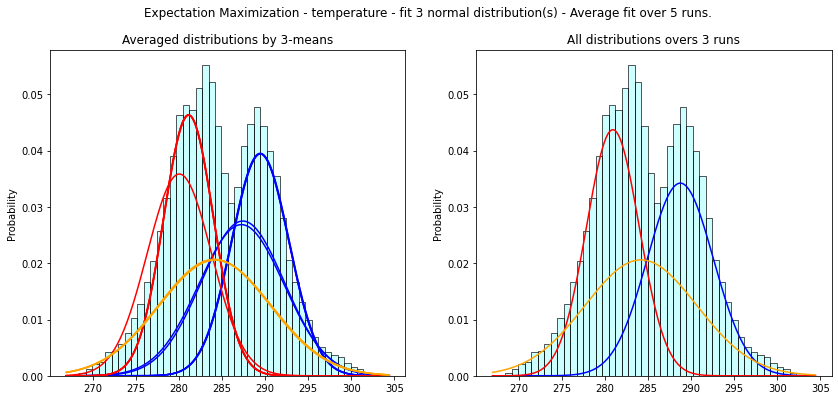

elapsed : 5.57 s.
Initial parameters :
	 - mu :    [287.8  286.33 282.53 282.57]
	 - sigma : [8.22 4.42 4.64 8.38]
	 - w :     [0.3  0.17 0.32 0.21]

Run number 0 over 5.
Initial parameters :
	 - mu :    [291.23 294.76 287.26 289.61]
	 - sigma : [6.24 2.6  4.33 2.35]
	 - w :     [0.21 0.24 0.28 0.27]
  8 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [279.05843514 289.1273386  282.21948562 289.33371274]
	sigma : [3.7604868  5.06334513 2.19364662 2.45303366]
	w :     [0.252145   0.2487563  0.25310095 0.24599775]

Run number 1 over 5.
Initial parameters :
	 - mu :    [273.01 277.36 285.34 288.54]
	 - sigma : [3.26 3.86 7.52 3.51]
	 - w :     [0.21 0.29 0.23 0.27]
  3 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [279.09956292 282.1969132  289.10821907 289.34093927]
	sigma : [3.78908831 2.20649676 5.07011574 2.45751493]
	w :     [0.25213702 0.2530206  0.24877919 0.24606319]

Run number 2 over 5.
Initial parameters :
	 - mu :  

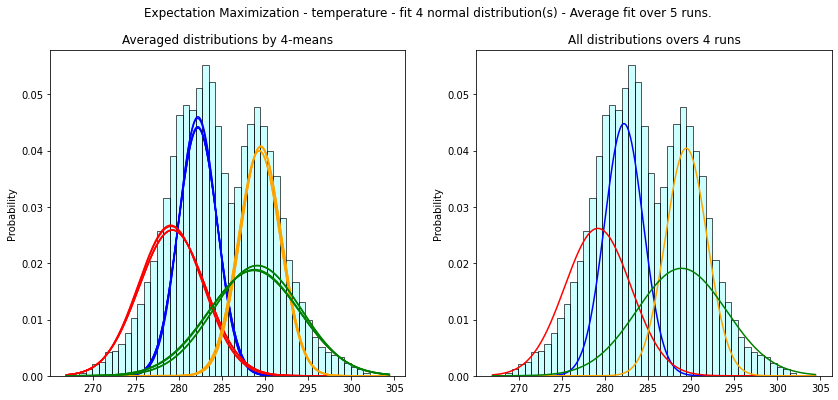

elapsed : 7.03 s.



	 humidity



Initial parameters :
	 - mu :    [78.17 81.01]
	 - sigma : [11.96 16.41]
	 - w :     [0.44 0.56]

Run number 0 over 5.
Initial parameters :
	 - mu :    [77.13 75.78]
	 - sigma : [8.74 8.08]
	 - w :     [0.62 0.38]
  3 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [86.48330085 75.36228901]
	sigma : [6.25714723 9.51327681]
	w :     [0.50045262 0.49954738]

Run number 1 over 5.
Initial parameters :
	 - mu :    [78.51 76.72]
	 - sigma : [12.89  9.39]
	 - w :     [0.52 0.48]
  3 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [75.34922656 86.50150758]
	sigma : [9.50133674 6.25401827]
	w :     [0.49960705 0.50039295]

Run number 2 over 5.
Initial parameters :
	 - mu :    [82.32 87.33]
	 - sigma : [10.63  7.37]
	 - w :     [0.47 0.53]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [75.34509837 86.49393656]
	sigma : [9.50510299 6.25294184]
	w :     [0.49959451 0.5

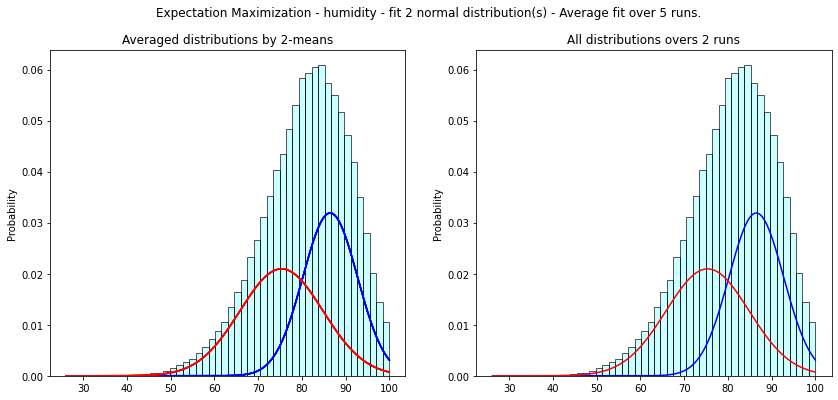

elapsed : 1.91 s.
Initial parameters :
	 - mu :    [72.9  86.22 79.11]
	 - sigma : [12.21 12.22 11.62]
	 - w :     [0.31 0.39 0.31]

Run number 0 over 5.
Initial parameters :
	 - mu :    [78.6  78.67 83.1 ]
	 - sigma : [11.39 13.69  9.02]
	 - w :     [0.31 0.31 0.38]
  8 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [80.27904223 72.56054325 89.98437745]
	sigma : [5.24745664 9.25455548 4.69542682]
	w :     [0.33454313 0.3337419  0.33171497]

Run number 1 over 5.
Initial parameters :
	 - mu :    [81.78 78.38 76.73]
	 - sigma : [13.05 10.02  9.68]
	 - w :     [0.4 0.3 0.3]
 12 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [89.98883172 80.28134971 72.55763615]
	sigma : [4.69482666 5.24972981 9.25160642]
	w :     [0.33169802 0.33454425 0.33375773]

Run number 2 over 5.
Initial parameters :
	 - mu :    [74.25 85.94 77.54]
	 - sigma : [ 7.07  6.97 11.02]
	 - w :     [0.5  0.17 0.33]
  8 %

Threshold reached, less than 0.1 % diffe

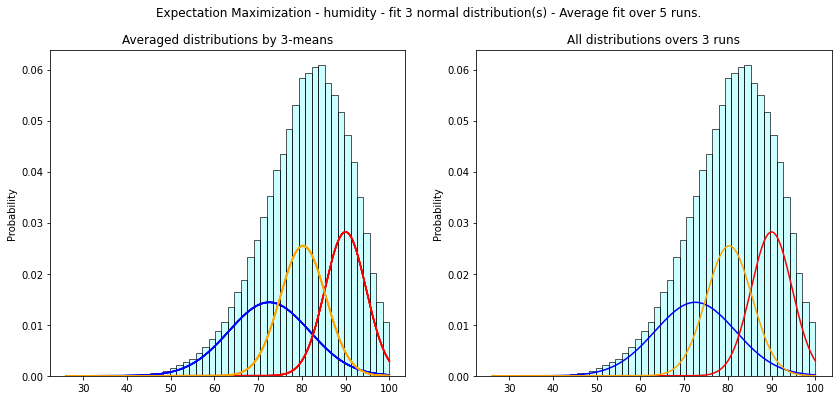

elapsed : 5.71 s.
Initial parameters :
	 - mu :    [84.72 79.2  94.88 81.84]
	 - sigma : [ 7.14 10.01  6.33  9.15]
	 - w :     [0.25 0.26 0.25 0.24]

Run number 0 over 5.
Initial parameters :
	 - mu :    [85.39 79.03 77.36 84.79]
	 - sigma : [12.8   9.29  7.85  7.31]
	 - w :     [0.29 0.26 0.28 0.17]
 19 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [83.79216531 71.12149607 77.12103903 91.72648351]
	sigma : [3.91502338 9.28979407 5.61918005 3.90111774]
	w :     [0.25053944 0.24993015 0.25069249 0.24883791]

Run number 1 over 5.
Initial parameters :
	 - mu :    [79.19 72.91 74.38 82.57]
	 - sigma : [6.93 6.04 8.32 7.76]
	 - w :     [0.25 0.29 0.23 0.23]
 17 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [83.77860452 77.13718961 71.13273124 91.71824398]
	sigma : [3.92841382 5.63562706 9.29981827 3.91028679]
	w :     [0.2505378  0.25069673 0.2499313  0.24883417]

Run number 2 over 5.
Initial parameters :
	 - mu :    [81.92 86.

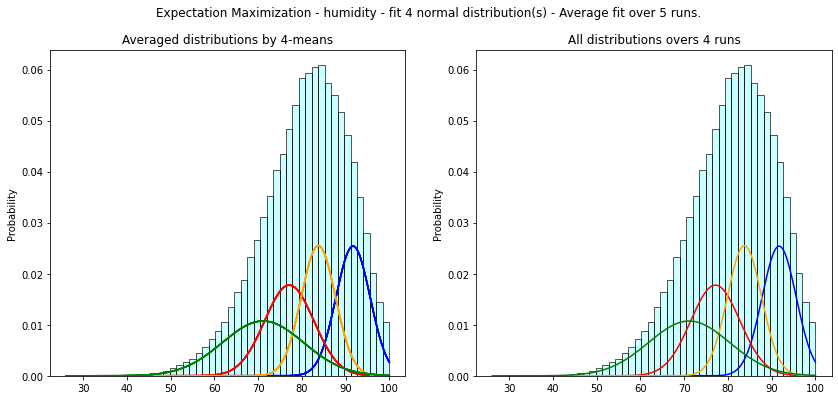

elapsed : 14.86 s.



	 dew_point



Initial parameters :
	 - mu :    [279.54 277.51]
	 - sigma : [6.88 2.35]
	 - w :     [0.6 0.4]

Run number 0 over 5.
Initial parameters :
	 - mu :    [292.61 283.25]
	 - sigma : [8.95 5.71]
	 - w :     [0.59 0.41]
  4 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [285.19298159 277.73992051]
	sigma : [2.89601088 3.74458252]
	w :     [0.48668672 0.51331328]

Run number 1 over 5.
Initial parameters :
	 - mu :    [281.61 288.63]
	 - sigma : [6.93 6.6 ]
	 - w :     [0.53 0.47]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [277.73655874 285.19460943]
	sigma : [3.74481575 2.89597438]
	w :     [0.51332811 0.48667189]

Run number 2 over 5.
Initial parameters :
	 - mu :    [289.97 286.62]
	 - sigma : [2.99 5.2 ]
	 - w :     [0.5 0.5]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [285.21381893 277.73985339]
	sigma : [2.88008633 3.73686976]
	w :     [0.485621

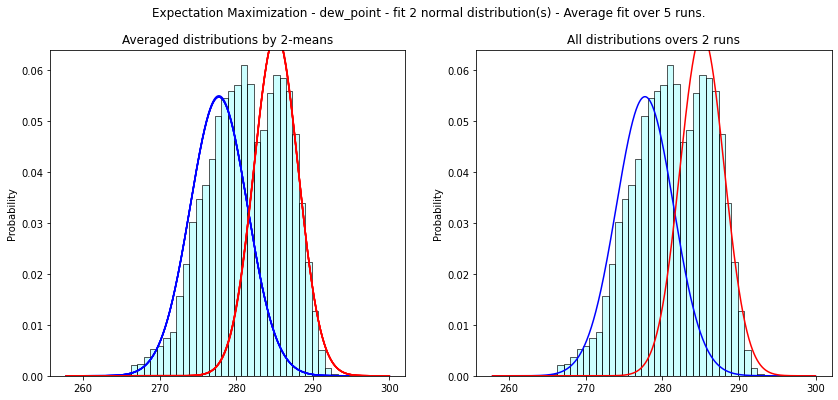

elapsed : 1.71 s.
Initial parameters :
	 - mu :    [279.88 279.68 283.92]
	 - sigma : [4.86 7.47 5.49]
	 - w :     [0.33 0.35 0.32]

Run number 0 over 5.
Initial parameters :
	 - mu :    [282.97 281.03 279.78]
	 - sigma : [8.69 4.22 2.11]
	 - w :     [0.36 0.35 0.29]
 11 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [280.39222692 286.51992986 277.2504521 ]
	sigma : [3.04671965 2.10591771 4.16603984]
	w :     [0.33430986 0.33111158 0.33457856]

Run number 1 over 5.
Initial parameters :
	 - mu :    [291.75 280.06 285.62]
	 - sigma : [0.06 4.69 6.07]
	 - w :     [0.34 0.31 0.35]
  3 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [286.56476898 276.79802663 280.76504978]
	sigma : [2.07791577 3.86902912 2.82304063]
	w :     [0.33192034 0.33412678 0.33395288]

Run number 2 over 5.
Initial parameters :
	 - mu :    [280.7  269.56 279.89]
	 - sigma : [6.17 6.2  6.08]
	 - w :     [0.32 0.36 0.32]
  5 %

Threshold reached, less than 0.

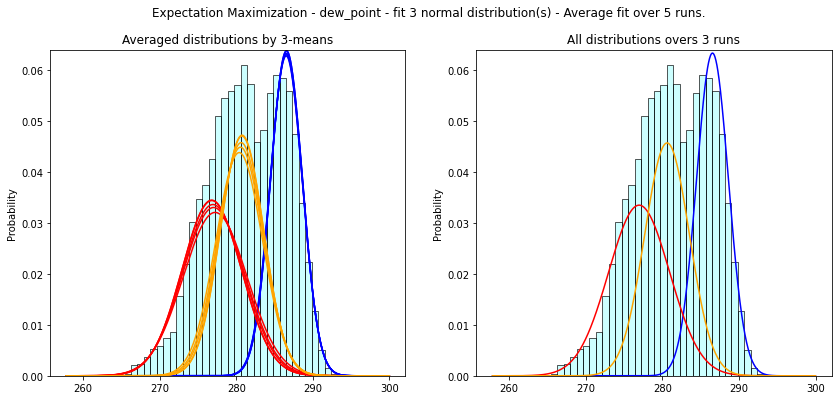

elapsed : 3.59 s.
Initial parameters :
	 - mu :    [282.73 287.18 274.25 285.29]
	 - sigma : [5.73 3.49 6.38 7.51]
	 - w :     [0.21 0.29 0.31 0.19]

Run number 0 over 5.
Initial parameters :
	 - mu :    [278.24 290.82 278.81 281.57]
	 - sigma : [7.08 6.83 3.93 3.79]
	 - w :     [0.2  0.26 0.3  0.24]
  3 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [278.29069878 286.86428759 278.56688233 281.69449248]
	sigma : [4.4962554  1.91769926 4.19072741 3.3911318 ]
	w :     [0.24938645 0.25159961 0.24938045 0.24963349]

Run number 1 over 5.
Initial parameters :
	 - mu :    [274.88 281.18 280.23 279.62]
	 - sigma : [7.2  5.68 4.26 2.77]
	 - w :     [0.23 0.24 0.29 0.24]
  4 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [278.04878954 286.86488809 281.65326111 278.85306406]
	sigma : [4.4223602  1.91626084 3.41339931 4.24242942]
	w :     [0.24941119 0.25159227 0.24960891 0.24938763]

Run number 2 over 5.
Initial parameters :
	 - mu :  

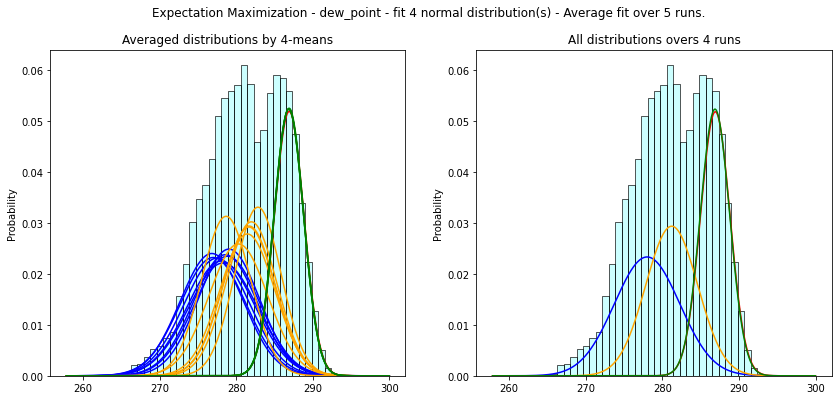

elapsed : 4.21 s.



	 current_precipitations



Initial parameters :
	 - mu :    [ 6.55 -3.08]
	 - sigma : [8.8 5. ]
	 - w :     [0.64 0.36]

Run number 0 over 5.
Initial parameters :
	 - mu :    [9.57 3.63]
	 - sigma : [0.34 3.97]
	 - w :     [0.49 0.51]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [4.66441797 0.07039739]
	sigma : [5.52926925 0.11064238]
	w :     [0.41183521 0.58816479]

Run number 1 over 5.
Initial parameters :
	 - mu :    [ 2.52 -3.14]
	 - sigma : [3.87 2.8 ]
	 - w :     [0.67 0.33]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [4.66433815 0.07059306]
	sigma : [5.52520096 0.11089674]
	w :     [0.41150197 0.58849803]

Run number 2 over 5.
Initial parameters :
	 - mu :    [-6.27 -1.27]
	 - sigma : [6.68 2.33]
	 - w :     [0.65 0.35]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [4.65941762 0.07053947]
	sigma : [5.52257678 0.11076205]
	w :     [0.41167937 0.588

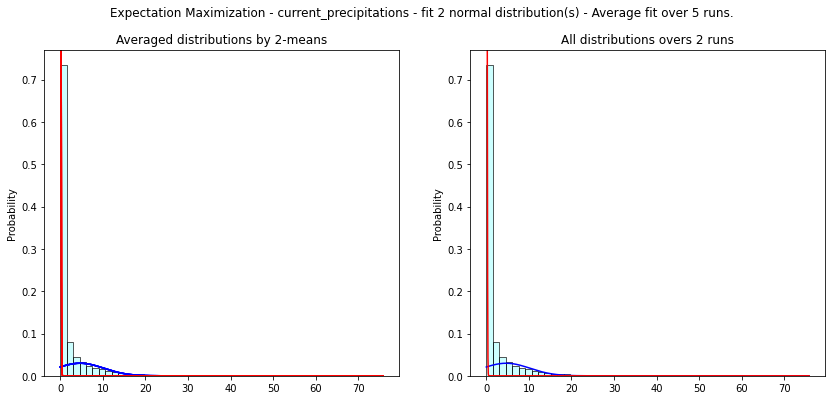

elapsed : 1.81 s.
Initial parameters :
	 - mu :    [ 1.23 -5.15 -6.57]
	 - sigma : [5.45 8.15 3.06]
	 - w :     [0.36 0.28 0.36]

Run number 0 over 5.
Initial parameters :
	 - mu :    [-11.1    4.46   0.35]
	 - sigma : [0.65 5.36 5.67]
	 - w :     [0.31 0.28 0.41]

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [0.         5.4122869  0.28659202]
	sigma : [1.00000000e-05 5.68333309e+00 1.39467040e-01]
	w :     [0.41104783 0.35029429 0.23865788]

Run number 1 over 5.
Initial parameters :
	 - mu :    [ 3.16 10.23  2.19]
	 - sigma : [5.81 3.06 5.05]
	 - w :     [0.3  0.34 0.35]

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [0.28632793 5.39682073 0.        ]
	sigma : [1.39187943e-01 5.65799677e+00 1.00000000e-05]
	w :     [0.23876766 0.35011418 0.41111815]

Run number 2 over 5.
Initial parameters :
	 - mu :    [-1.14  2.94  4.23]
	 - sigma : [7.52 4.43 5.92]
	 - w :     [0.32 0.31 0.36]
ARNING : sigma < minimum_sigma - 0.0000000 < 0.

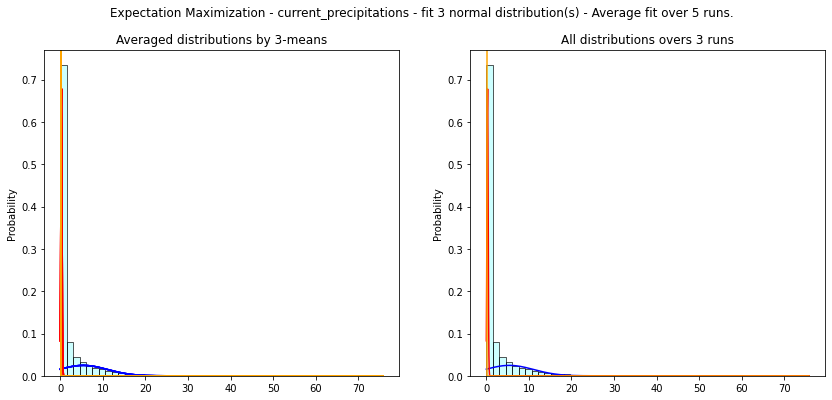

elapsed : 6.92 s.
Initial parameters :
	 - mu :    [9.24 0.65 2.1  3.73]
	 - sigma : [2.06 2.28 5.2  1.06]
	 - w :     [0.26 0.27 0.29 0.18]

Run number 0 over 5.
Initial parameters :
	 - mu :    [-4.54 -1.04  3.8  -2.74]
	 - sigma : [8.46 1.68 3.9  6.81]
	 - w :     [0.22 0.35 0.29 0.14]

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [8.46086601 0.         0.23759248 1.56501286]
	sigma : [6.23868531e+00 1.00000000e-05 7.81682944e-02 9.82563469e-01]
	w :     [0.18867913 0.41090926 0.19654693 0.20386468]

Run number 1 over 5.
Initial parameters :
	 - mu :    [-6.42 -7.44  9.01  3.97]
	 - sigma : [5.77 3.32 1.49 2.44]
	 - w :     [0.28 0.23 0.27 0.22]

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [8.45961272 0.         1.56444457 0.23772551]
	sigma : [6.23109184e+00 1.00000000e-05 9.81412125e-01 7.82752694e-02]
	w :     [0.18874846 0.4110499  0.20354705 0.19665459]

Run number 2 over 5.
Initial parameters :
	 - mu :    [1.61 4.73

/tmp/ipykernel_264883/3880417712.py:78: RuntimeWarning: invalid value encountered in true_divide
  self.mu = np.sum(self.x * self.r, axis=1) / np.sum(self.r, axis=1)


 99 %

100 %
Final parameters :
	mu :    [nan nan nan nan]
	sigma : [nan nan nan nan]
	w :     [nan nan nan nan]
Most likely : 'Input contains NaN, infinity or a value too large for dtype('float64').'
elapsed : 9.50 s.


In [20]:
for col in ['wind_speed', 'temperature', 'humidity', 'dew_point', 'current_precipitations']:
    print("\n\n", "=" * 50, sep="")
    print("\n\t", col)
    print("\n", "=" * 50, "\n\n", sep="")
    for k in range(2, 5):
        em = EM(x=df[col].to_numpy(), nb_dist=k, split_ratio=0.01, threshold=0.001, talk=True)
        t = time.time()
        try :
            em.average_fit(runs=5, max_iters=1000, plot=True, plot_title="Expectation Maximization - {} - fit {} normal distribution(s) - Average fit over 5 runs.".format(col, k))
        except ValueError :
            print("Most likely : 'Input contains NaN, infinity or a value too large for dtype('float64').'")
        print("elapsed : {:.2f} s.".format(time.time() - t))




	 wind_speed



Initial parameters :
	 - mu :    [1.43]
	 - sigma : [4.18]
	 - w :     [1.]
  0 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [3.54626141]
	sigma : [1.95563732]
	w :     [1.]
elapsed : 0.01 s.


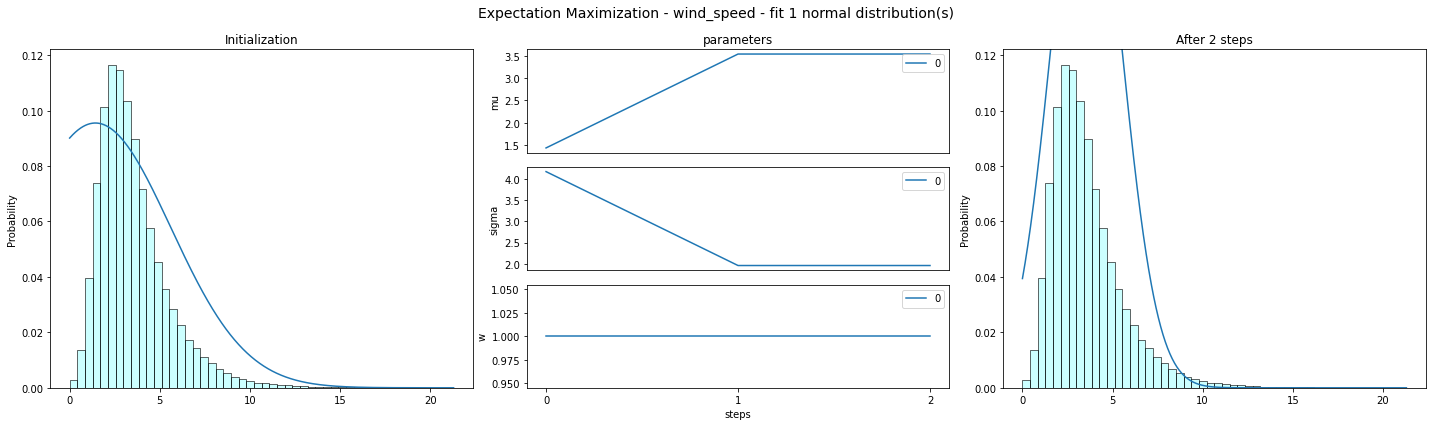

Initial parameters :
	 - mu :    [10.05 -0.46]
	 - sigma : [1.12 1.83]
	 - w :     [0.48 0.52]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [4.61948517 2.58106877]
	sigma : [2.23864695 0.89504644]
	w :     [0.47375587 0.52624413]
elapsed : 0.09 s.


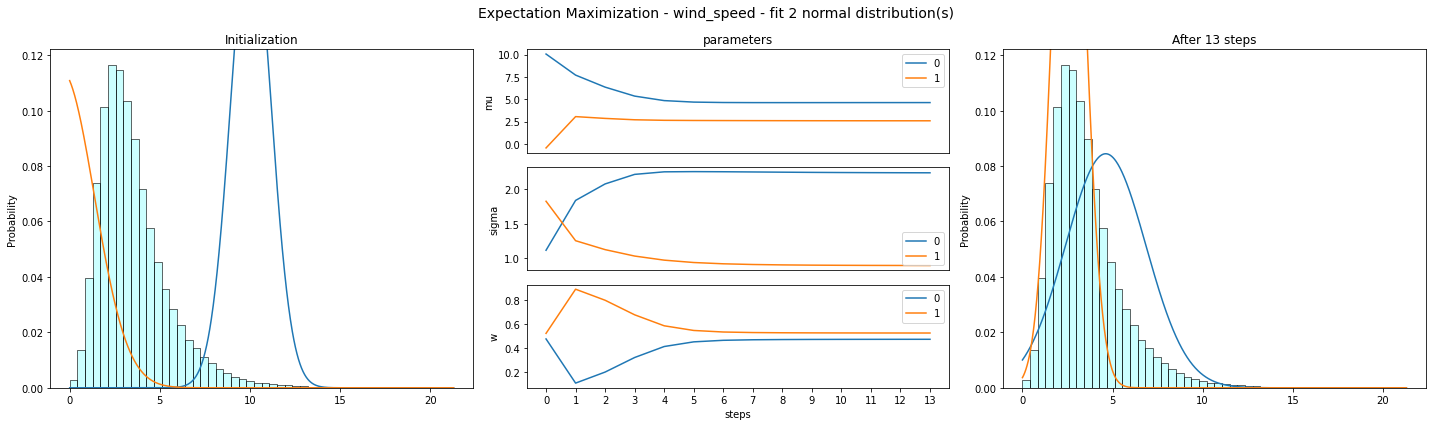

Initial parameters :
	 - mu :    [16.57  2.91 11.77]
	 - sigma : [3.44 1.11 4.99]
	 - w :     [0.31 0.4  0.29]
  4 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [5.16834966 2.10439105 3.49226426]
	sigma : [2.39978556 0.68699305 0.94769796]
	w :     [0.31580679 0.34151104 0.34268218]
elapsed : 0.52 s.


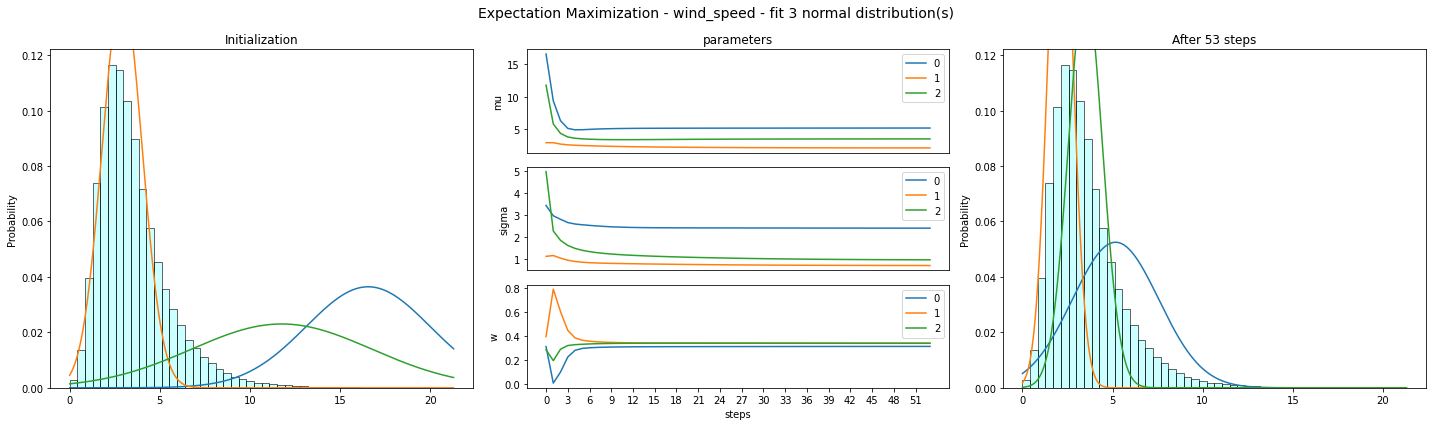

Initial parameters :
	 - mu :    [2.64 1.37 3.57 5.02]
	 - sigma : [2.45 2.56 2.02 2.33]
	 - w :     [0.21 0.28 0.26 0.24]
 15 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [2.91933132 1.83817428 4.01461065 5.54057561]
	sigma : [0.67077529 0.58997485 1.0533635  2.51269604]
	w :     [0.25421558 0.25376042 0.25416167 0.23786234]
elapsed : 2.32 s.


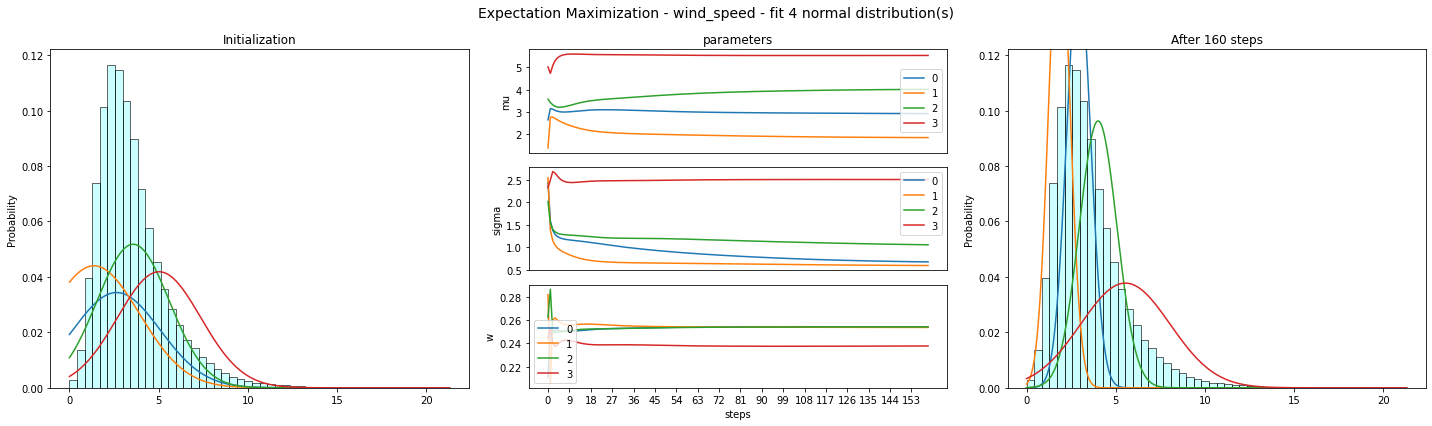




	 temperature



Initial parameters :
	 - mu :    [286.81]
	 - sigma : [4.6]
	 - w :     [1.]
  0 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [284.89543425]
	sigma : [5.68632415]
	w :     [1.]
elapsed : 0.01 s.


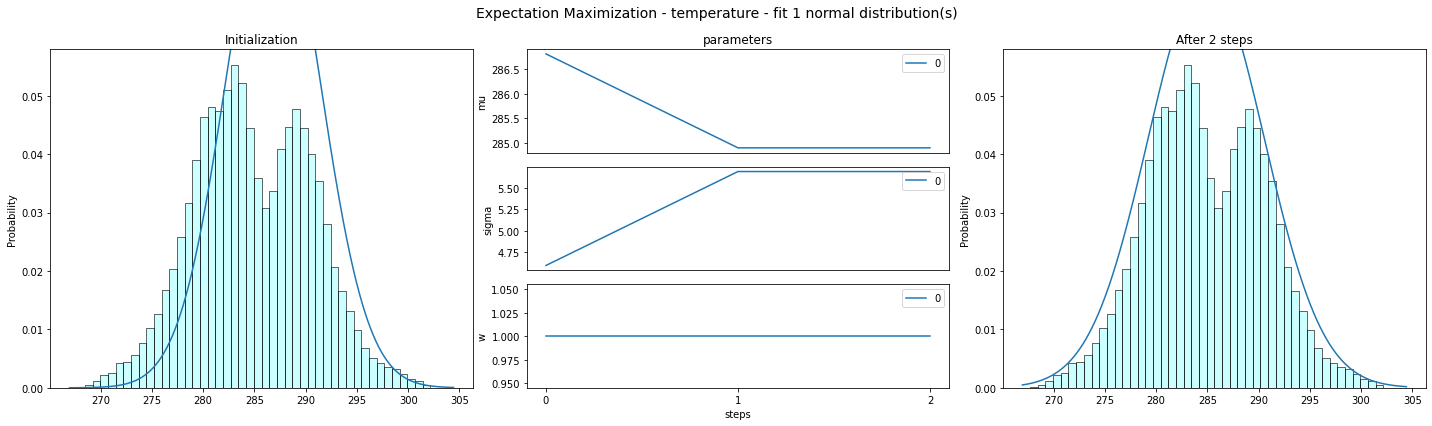

Initial parameters :
	 - mu :    [283.33 284.  ]
	 - sigma : [3.94 5.09]
	 - w :     [0.49 0.51]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [283.75142614 286.02979477]
	sigma : [5.41991453 5.71768468]
	w :     [0.49986928 0.50013072]
elapsed : 0.11 s.


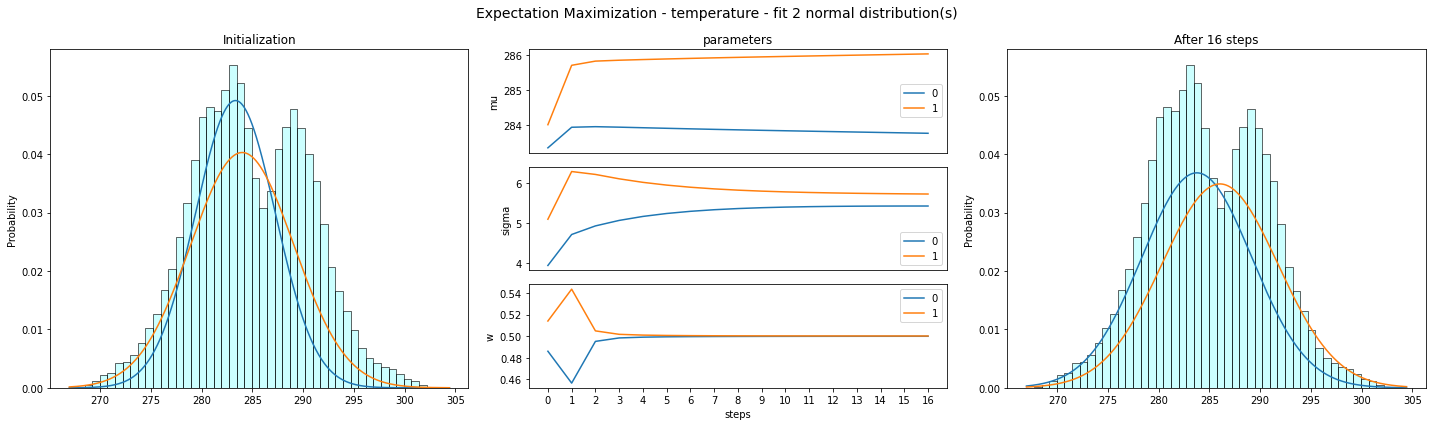

Initial parameters :
	 - mu :    [293.71 281.67 287.32]
	 - sigma : [8.35 6.2  6.6 ]
	 - w :     [0.31 0.32 0.37]
  6 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [289.42583831 281.12153582 284.22243935]
	sigma : [3.32560439 2.88325317 6.51194892]
	w :     [0.32911045 0.33546854 0.33542101]
elapsed : 0.71 s.


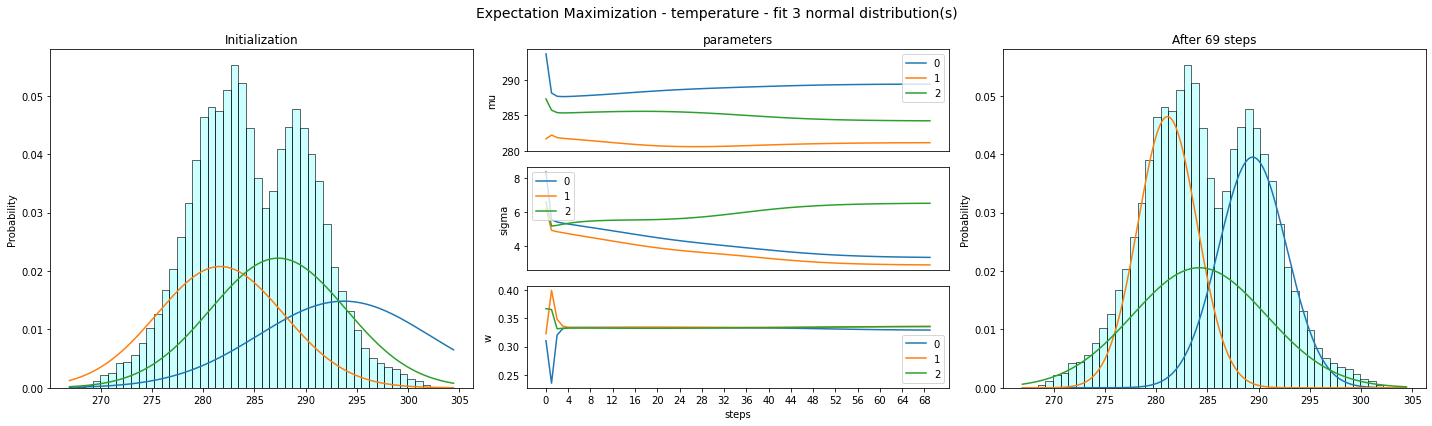

Initial parameters :
	 - mu :    [286.77 281.27 287.67 283.69]
	 - sigma : [4.32 4.39 6.22 4.53]
	 - w :     [0.18 0.3  0.32 0.2 ]
 11 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [289.4955684  282.20678407 288.77470456 279.24681366]
	sigma : [2.41568345 2.27644127 5.29195231 3.8780008 ]
	w :     [0.24626549 0.25231873 0.24967595 0.25173982]
elapsed : 1.61 s.


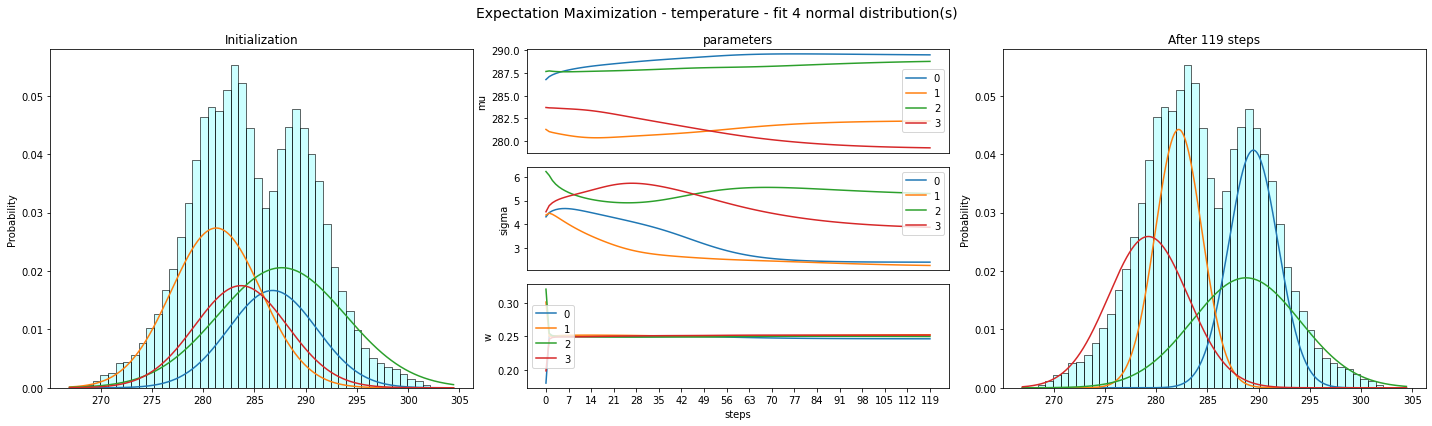




	 humidity



Initial parameters :
	 - mu :    [84.18]
	 - sigma : [11.09]
	 - w :     [1.]
  0 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [80.92846612]
	sigma : [9.78551683]
	w :     [1.]
elapsed : 0.01 s.


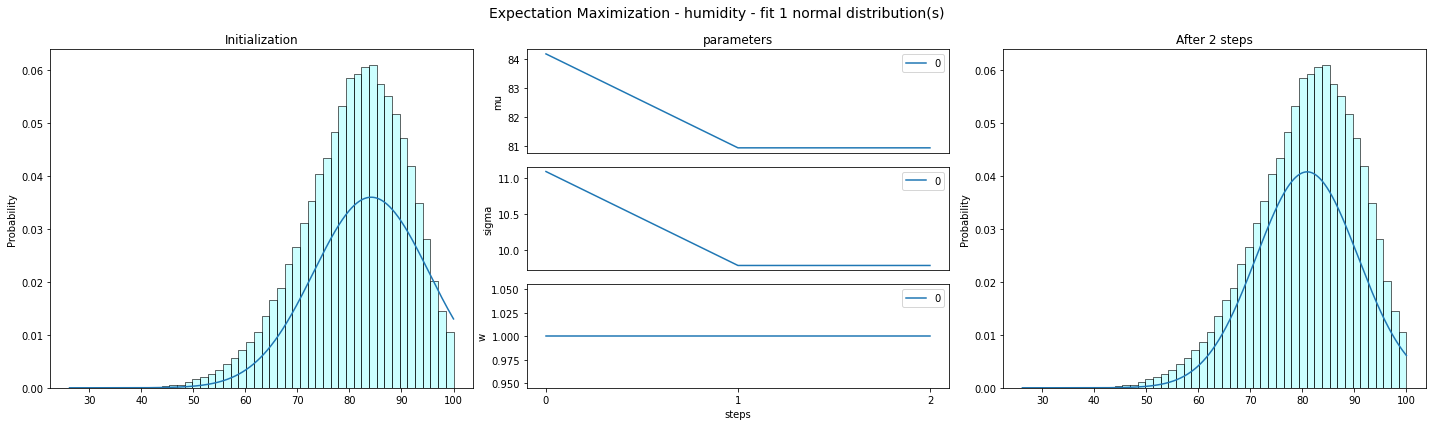

Initial parameters :
	 - mu :    [81.37 86.15]
	 - sigma : [11.12  9.9 ]
	 - w :     [0.44 0.56]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [75.34772645 86.48707261]
	sigma : [9.50927013 6.25833478]
	w :     [0.49959878 0.50040122]
elapsed : 0.20 s.


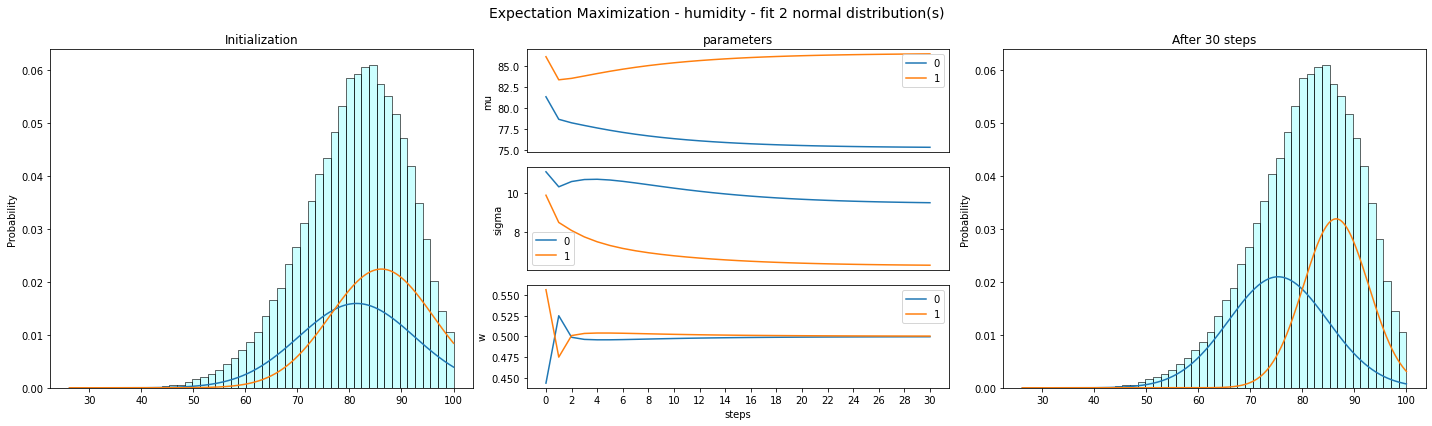

Initial parameters :
	 - mu :    [86.56 70.52 87.64]
	 - sigma : [11.58  6.56 11.26]
	 - w :     [0.38 0.27 0.35]
 12 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [80.29465684 72.5628432  89.98674966]
	sigma : [5.24482274 9.24548122 4.6926333 ]
	w :     [0.33453627 0.33375595 0.33170778]
elapsed : 1.23 s.


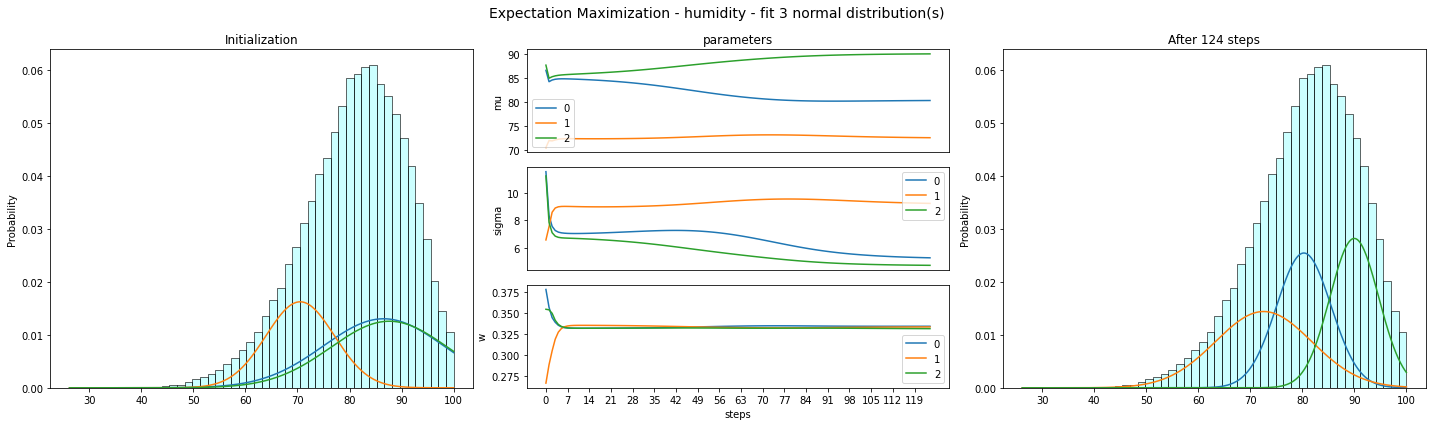

Initial parameters :
	 - mu :    [79.18 78.86 84.21 80.96]
	 - sigma : [12.77 11.49 11.22  6.43]
	 - w :     [0.22 0.22 0.33 0.23]
 19 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [71.12029698 77.17133981 83.77090694 91.71402278]
	sigma : [9.27618042 5.65186534 3.9465641  3.91107209]
	w :     [0.24993616 0.25071273 0.25051841 0.2488327 ]
elapsed : 2.79 s.


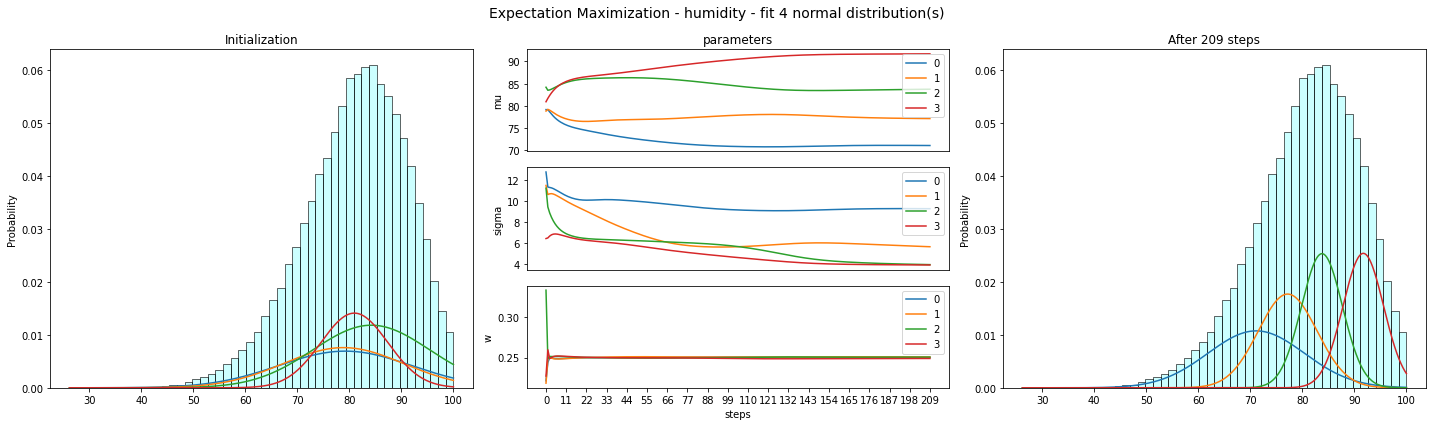




	 dew_point



Initial parameters :
	 - mu :    [272.57]
	 - sigma : [6.61]
	 - w :     [1.]
  0 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [281.36572058]
	sigma : [5.01546053]
	w :     [1.]
elapsed : 0.01 s.


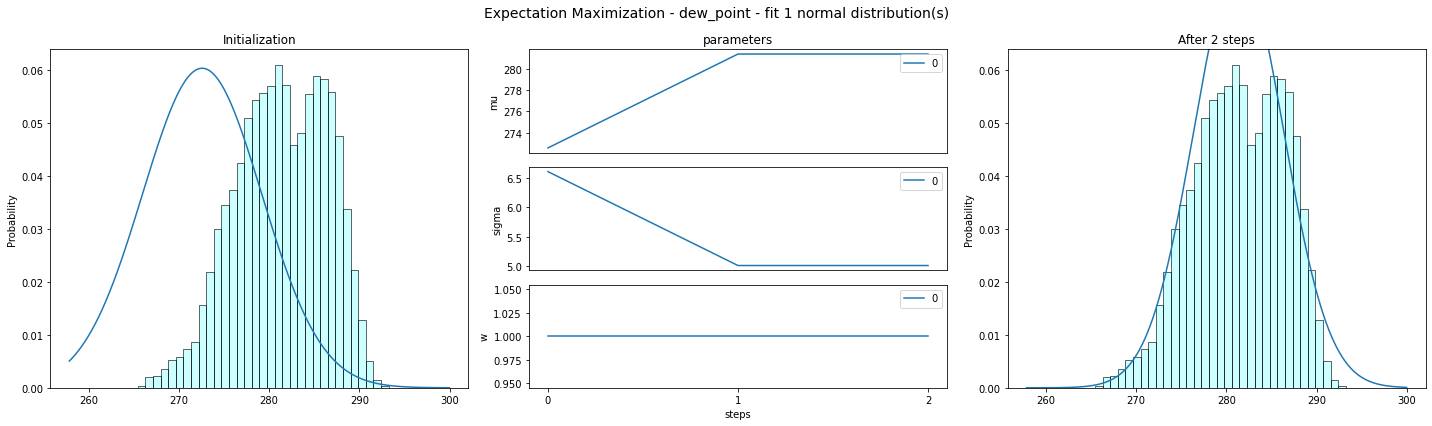

Initial parameters :
	 - mu :    [285.64 270.82]
	 - sigma : [5.92 5.98]
	 - w :     [0.47 0.53]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [285.19132009 277.73728229]
	sigma : [2.89535407 3.74212686]
	w :     [0.48666138 0.51333862]
elapsed : 0.13 s.


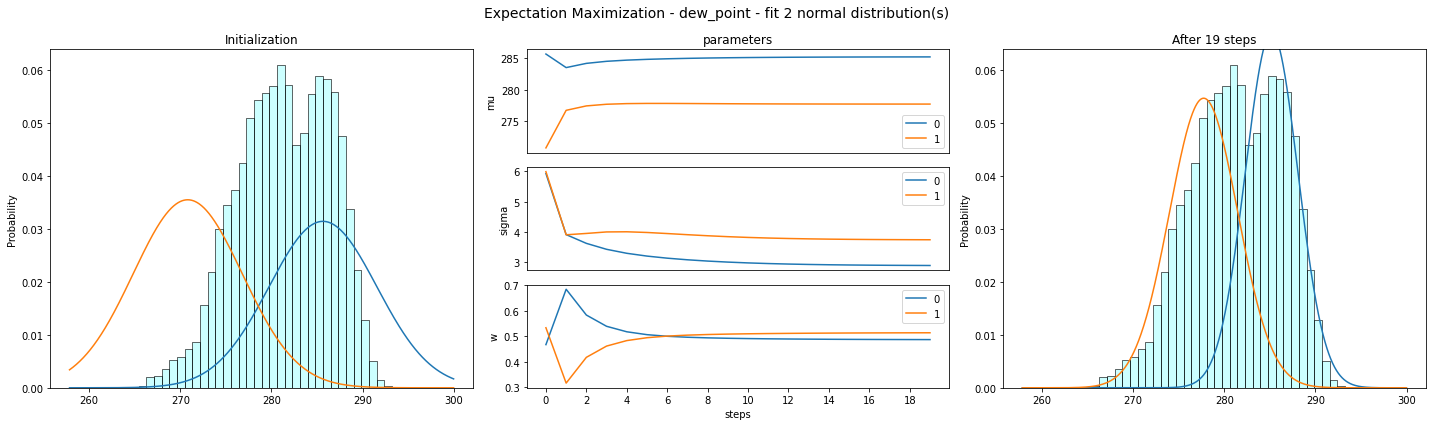

Initial parameters :
	 - mu :    [280.37 284.15 284.18]
	 - sigma : [5.82 2.7  3.71]
	 - w :     [0.24 0.31 0.45]
  4 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [277.11347828 286.53225648 280.50616978]
	sigma : [4.08564037 2.09914604 2.99696978]
	w :     [0.33452474 0.33113807 0.33433719]
elapsed : 0.50 s.


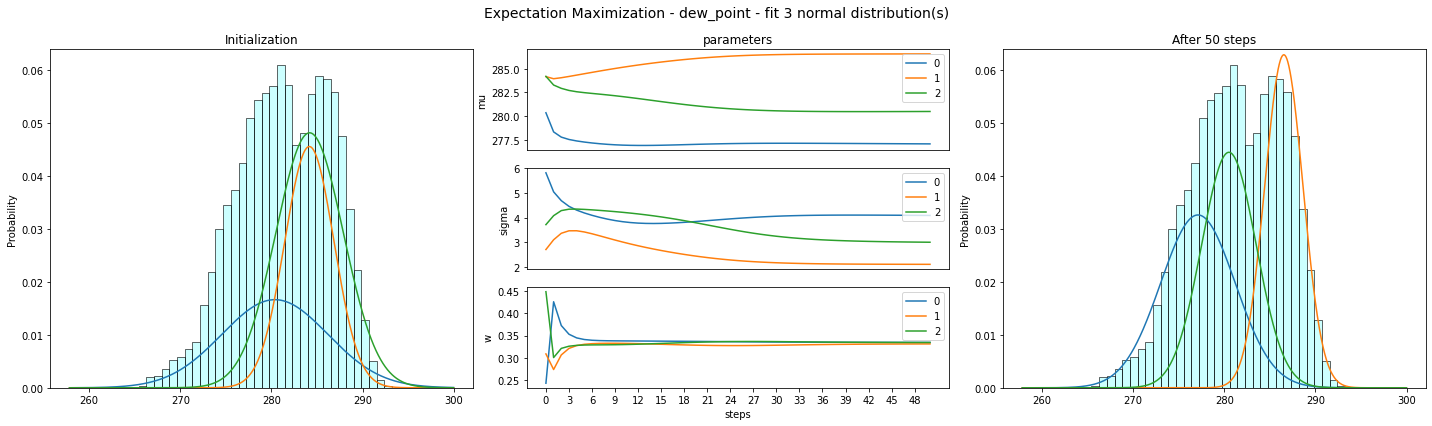

Initial parameters :
	 - mu :    [285.84 271.04 270.2  279.41]
	 - sigma : [5.52 4.49 6.85 5.54]
	 - w :     [0.21 0.29 0.19 0.3 ]
  3 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [286.89120843 277.15769981 279.37644762 281.99302708]
	sigma : [1.9153561  4.22888418 3.90912684 3.3349071 ]
	w :     [0.25142656 0.24952591 0.24953091 0.24951663]
elapsed : 0.52 s.


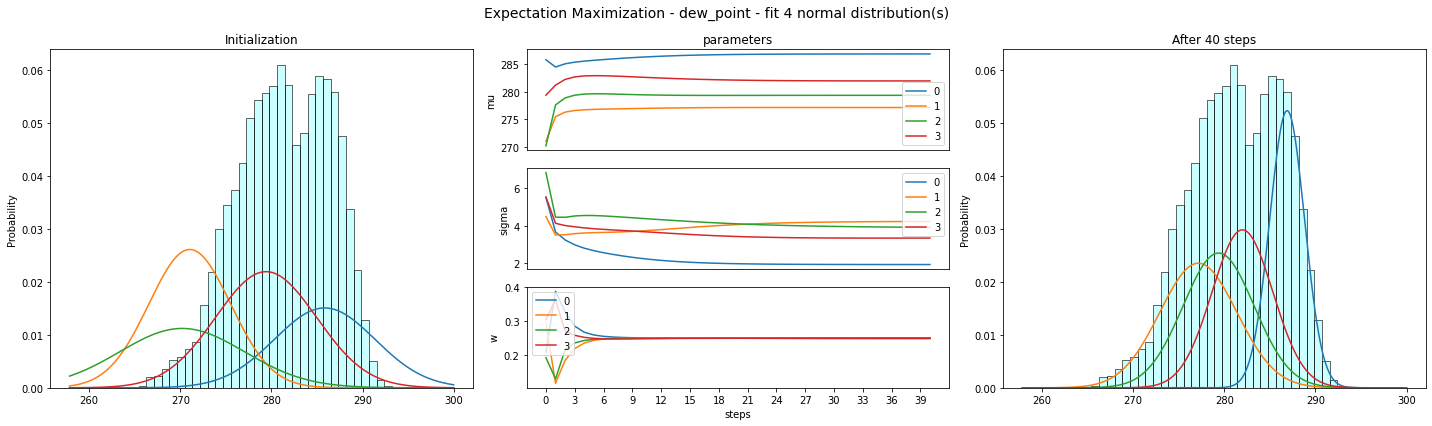




	 current_precipitations



Initial parameters :
	 - mu :    [-3.48]
	 - sigma : [7.52]
	 - w :     [1.]
  0 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [1.962419]
	sigma : [4.20513342]
	w :     [1.]
elapsed : 0.01 s.


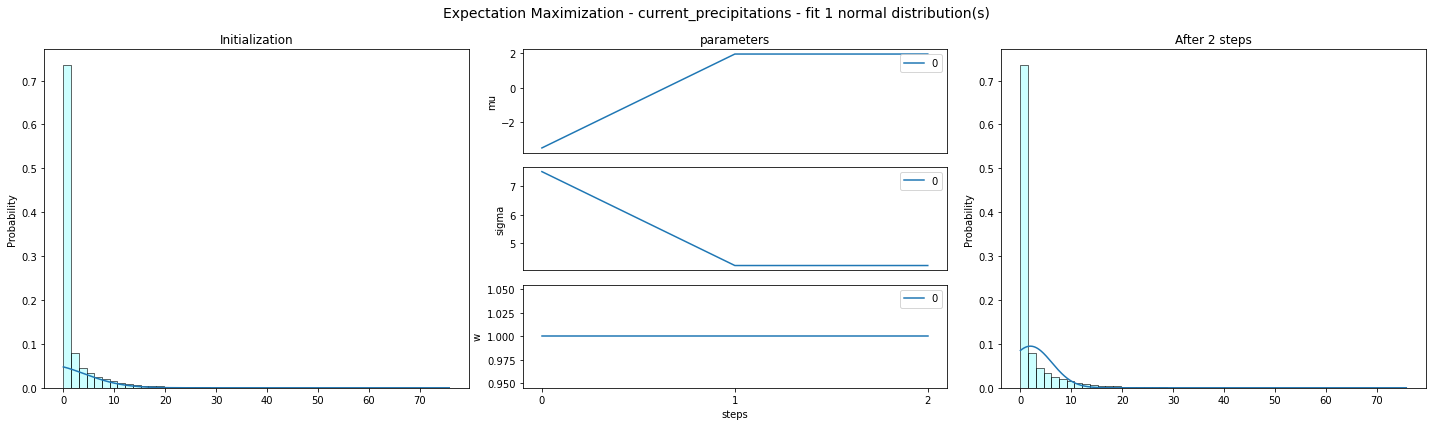

Initial parameters :
	 - mu :    [ 2.95 -1.41]
	 - sigma : [6.09 5.  ]
	 - w :     [0.47 0.53]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [4.65305296 0.07009399]
	sigma : [5.51294048 0.11027194]
	w :     [0.41255889 0.58744111]
elapsed : 0.23 s.


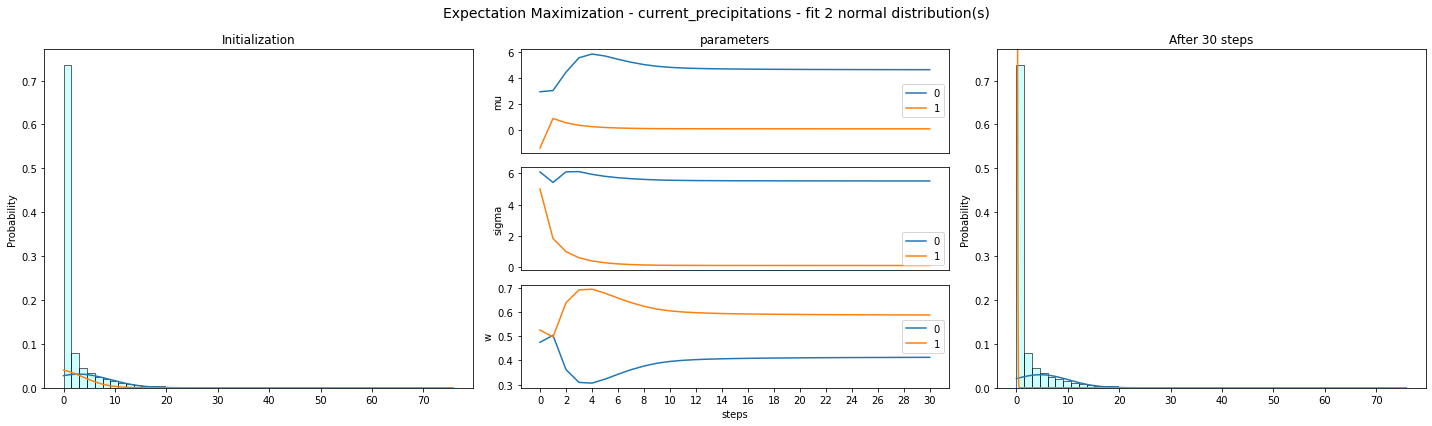

Initial parameters :
	 - mu :    [5.19 3.68 6.28]
	 - sigma : [2.58 7.6  4.23]
	 - w :     [0.28 0.39 0.33]

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [0.         5.40256056 0.28637948]
	sigma : [1.00000000e-05 5.67196091e+00 1.39308842e-01]
	w :     [0.41102439 0.35029513 0.23868048]
elapsed : 1.19 s.


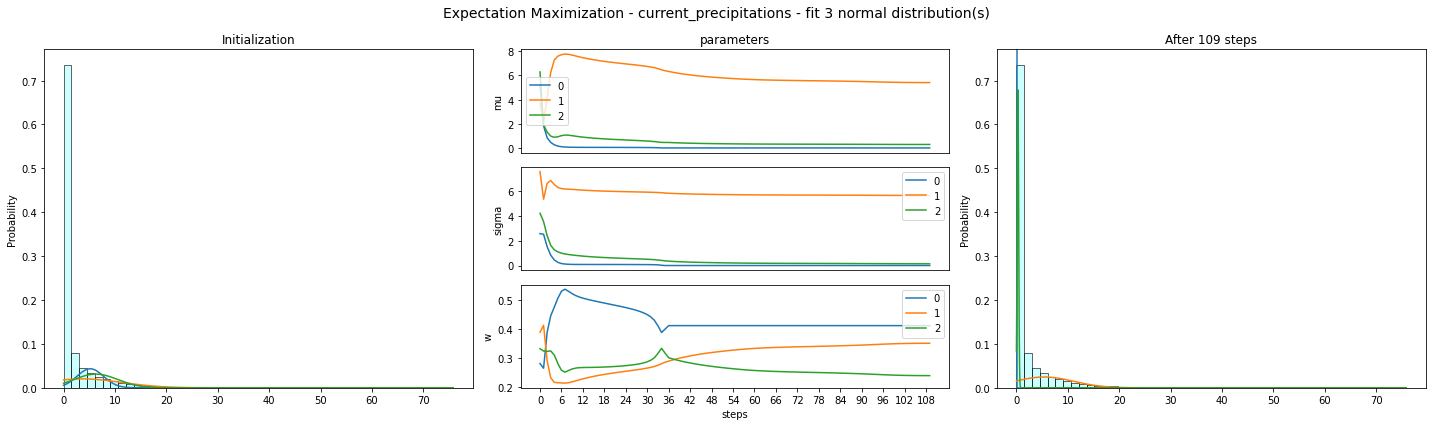

Initial parameters :
	 - mu :    [ 2.3   0.    1.42 -0.92]
	 - sigma : [6.09 7.53 2.78 6.07]
	 - w :     [0.26 0.22 0.28 0.24]

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [1.57105798 8.46628276 0.         0.23788578]
	sigma : [9.85822850e-01 6.21820614e+00 1.00000000e-05 7.84041883e-02]
	w :     [0.20374434 0.18837216 0.41108506 0.19679844]
elapsed : 0.60 s.


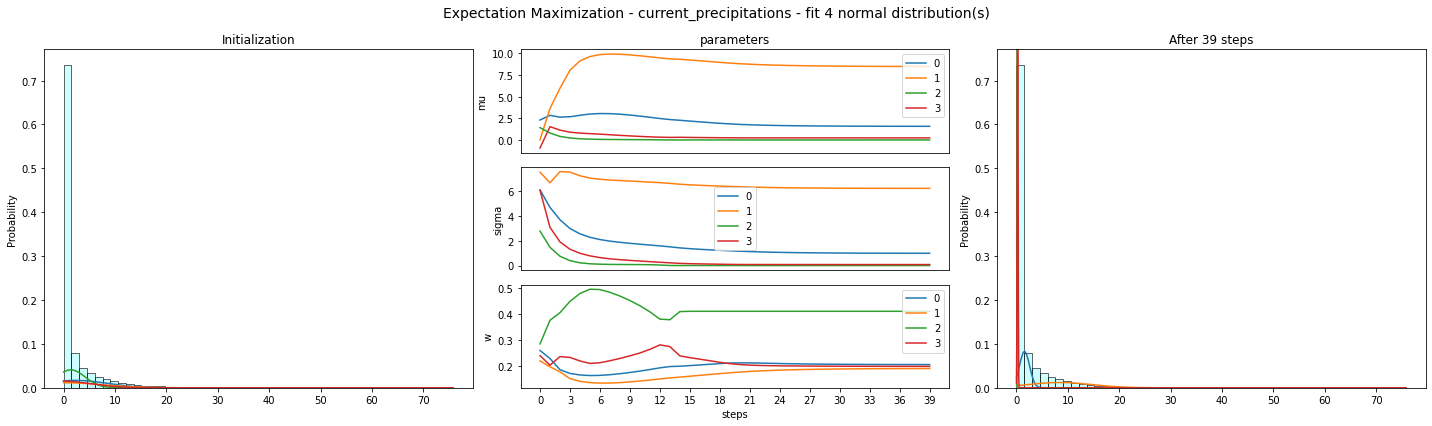

In [21]:
for col in ['wind_speed', 'temperature', 'humidity', 'dew_point', 'current_precipitations']:
    print("\n\n", "=" * 50, sep="")
    print("\n\t", col)
    print("\n", "=" * 50, "\n\n", sep="")
    for k in range(1, 5):
        em = EM(x=df[col].to_numpy(), nb_dist=k, split_ratio=0.01, threshold=0.001, talk=True)
        t = time.time()
        em.fit(max_iters=1000)
        print("elapsed : {:.2f} s.".format(time.time() - t))
        em.plot_progression(title="Expectation Maximization - {} - fit {} normal distribution(s)".format(col, k))